In [1]:
import warnings

# Suppress the warning related to PyDataset class
warnings.simplefilter(action='ignore', category=UserWarning)


In [2]:
import os
import shutil
import pathlib
import random
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


# Libraries for building the model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications import DenseNet121, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from sklearn.model_selection import StratifiedKFold, KFold


In [3]:
tf.keras.backend.clear_session()

In [3]:
!nvidia-smi

Tue May  7 12:56:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX350         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8             N/A /   14W |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:

#Number of images in each folder
# Root path where all the folders are located
root_path = r'C:\\Users\\FARHAN BASHIR\\OneDrive\\Desktop\\Diabetic Retinopathy\\archive\\colored_images\\colored_images'

# Specify the folders containing the classified diabetic retinopathy images
folders = [
    os.path.join(root_path, 'No_DR'),
    os.path.join(root_path, 'Mild'),
    os.path.join(root_path, 'Moderate'),
    os.path.join(root_path, 'Severe'),
    os.path.join(root_path, 'Proliferate_DR')
]

# Calculate the maximum number of images among all folders
print([len(os.listdir(folder)) for folder in folders])



[10000, 10000, 10000, 10000, 10000]


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='auto')

# Maximum number of images per class
max_images = 10000

# Iterate over each folder
for folder in folders:
    files = os.listdir(folder)
    num_images = len(files)
    if num_images == max_images:
        print(f"{folder} already contains {max_images} images.")
        continue
    
    if num_images < max_images:
        # Determine the number of images to generate or oversample
        num_to_add = max_images - num_images
        # Load images from the folder
        images = [np.array(Image.open(os.path.join(folder, file))) for file in files]
        # Reshape images for oversampling
        images = np.array(images).reshape(-1, image_height * image_width * num_channels)
        if num_images < max_images / 2:
            # Apply data augmentation if the number of images is less than half of max_images
            aug_images = []
            for X_batch in datagen.flow(images, batch_size=1):
                aug_images.append(X_batch[0].astype(np.uint8))
                if len(aug_images) >= num_to_add:
                    break
            # Save augmented images with unique names
            for i, aug_image in enumerate(aug_images, start=num_images + 1):
                Image.fromarray(aug_image).save(os.path.join(folder, f'aug_{i}.png'))
        else:
            # Apply oversampling if the number of images is greater than or equal to half of max_images
            X_resampled, _ = oversample.fit_resample(images, np.zeros(num_images))
            # Save resampled images with unique names
            for i, X_sampled in enumerate(X_resampled[num_images:], start=num_images + 1):
                Image.fromarray(X_sampled.reshape(image_height, image_width, num_channels).astype(np.uint8)).save(os.path.join(folder, f'sampled_{i}.png'))


C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images\No_DR already contains 10000 images.
C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images\Mild already contains 10000 images.
C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images\Moderate already contains 10000 images.
C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images\Severe already contains 10000 images.
C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images\Proliferate_DR already contains 10000 images.


In [5]:
# Root path where all the folders are located
root_path = r'C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images'
# Specify the folders containing the classified diabetic retinopathy images
folders = [
    os.path.join(root_path, 'No_DR'),
    os.path.join(root_path, 'Mild'),
    os.path.join(root_path, 'Moderate'),
    os.path.join(root_path, 'Severe'),
    os.path.join(root_path, 'Proliferate_DR')
]

# Calculate the maximum number of images among all folders
print([len(os.listdir(folder)) for folder in folders])



[10000, 10000, 10000, 10000, 10000]


# Preprocessing

In [6]:
import os
import cv2
import shutil
import matplotlib.pyplot as plt



def preprocess_image(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Apply CLAHE
    equalized_image = clahe.apply(gray_image)
    
    # Apply noise removal (e.g., Gaussian blur)
    denoised_image = cv2.GaussianBlur(equalized_image, (3, 3), 0)
    
    # Normalize the image (0-255 to 0-1)
    normalized_image = denoised_image / 255.0
    # Convert back to 8-bit unsigned integer
    normalized_image = (normalized_image * 255).astype('uint8')

    
    return normalized_image

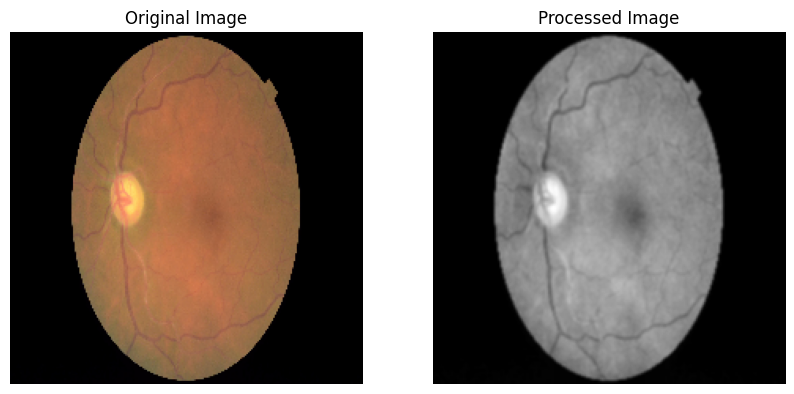

In [10]:
# Load an example image
image_path = r'C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images\Mild\15_left.png'
original_image = cv2.imread(image_path)

# Preprocess the image
processed_image = preprocess_image(original_image)

# Display the original and processed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Processed image
plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')

plt.show()

In [7]:
#preprocess all images in folders
# Root path where all the folders are located
root_path = r'C:\Users\User\Downloads\archive (1)\colored_images\colored_images'

# Specify the folders containing the classified diabetic retinopathy images
folders = [
    os.path.join(root_path, 'No_DR'),
    os.path.join(root_path, 'Mild'),
    os.path.join(root_path, 'Moderate'),
    os.path.join(root_path, 'Severe'),
    os.path.join(root_path, 'Proliferate_DR')
]

# Define the destination folders for preprocessed images
root_path2 = r'C:\Users\User\Downloads\archive (1)\colored_images\Cleaned Images'
preprocessed_folders = [
    os.path.join(root_path2, 'No_DR'),
    os.path.join(root_path2, 'Mild'),
    os.path.join(root_path2, 'Moderate'),
    os.path.join(root_path2, 'Severe'),
    os.path.join(root_path2, 'Proliferate_DR')
]

# Iterate over each folder and preprocess images
for src_folder, dest_folder in zip(folders, preprocessed_folders):
    # Create destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Iterate over each image in the source folder
    for filename in os.listdir(src_folder):
        # Read the image
        image_path = os.path.join(src_folder, filename)
        image = cv2.imread(image_path)
        
        # Preprocess the image
        preprocessed_image = preprocess_image(image)
        
        # Save the preprocessed image with the same filename in the destination folder
        dest_image_path = os.path.join(dest_folder, filename)
        cv2.imwrite(dest_image_path, preprocessed_image ) 


# Segmentation

In [7]:
def segment_lesions(image):
    # Convert the input image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding to detect microaneurysms and hemorrhages
    _, microaneurysms_mask = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    _, hemorrhages_mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    # Convert the input image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Thresholding to detect soft exudates
    soft_exudates_mask = cv2.inRange(hsv_image, (0, 50, 50), (30, 255, 255))

    # Thresholding to detect hard exudates
    hard_exudates_mask = cv2.inRange(hsv_image, (0, 0, 100), (30, 100, 255))

    # Combine all the individual masks into a single mask
    combined_mask = cv2.bitwise_or(microaneurysms_mask, hemorrhages_mask, soft_exudates_mask, hard_exudates_mask)

    # Apply morphological closing to fill in small holes and gaps in the mask
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours in the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask with the contour regions filled
    contour_mask = np.zeros_like(combined_mask)
    cv2.drawContours(contour_mask, contours, -1, (255), thickness=cv2.FILLED)

    # Apply the contour mask to the original image to segment the lesions
    segmented_image = cv2.bitwise_and(image, image, mask=contour_mask)

    return segmented_image


In [8]:
def highlight_lesions(image, mask, color=(0, 0, 255), thickness=2):
    # # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw red contours on the preprocessed image to highlight lesions
    highlighted_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(highlighted_image, contours, -1, color, thickness=2)

    return highlighted_image


In [19]:
# Root path where all the folders are located
preprocessed_img = r'C:\Users\User\Downloads\archive (1)\colored_images\Cleaned Images'

# Specify the folders containing the classified diabetic retinopathy images
folders = [
    os.path.join(preprocessed_img, 'No_DR'),
    os.path.join(preprocessed_img, 'Mild'),
    os.path.join(preprocessed_img, 'Moderate'),
    os.path.join(preprocessed_img, 'Severe'),
    os.path.join(preprocessed_img, 'Proliferate_DR')
]

# Define the destination folders for preprocessed images
segmented_img = r'C:\Users\User\Downloads\archive (1)\colored_images\segmented_images'
Segmented_folders = [
    os.path.join(segmented_img, 'No_DR'),
    os.path.join(segmented_img, 'Mild'),
    os.path.join(segmented_img, 'Moderate'),
    os.path.join(segmented_img, 'Severe'),
    os.path.join(segmented_img, 'Proliferate_DR')
]
display_flag = True

# Iterate over each folder and preprocess images
for src_folder, dest_folder in zip(folders, Segmented_folders):
    # Create destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Iterate over each image in the source folder
    for filename in os.listdir(src_folder):
        # Read the image
        image_path = os.path.join(src_folder, filename)
        image = cv2.imread(image_path)
        
        #segmentation of image
        segmented_image = segment_lesions(image)

       # Save the preprocessed image with the same filename in the destination folder
        dest_image_path = os.path.join(dest_folder, filename)
        cv2.imwrite(dest_image_path, segmented_image * 255)  # Multiply by 255 to convert back to uint8

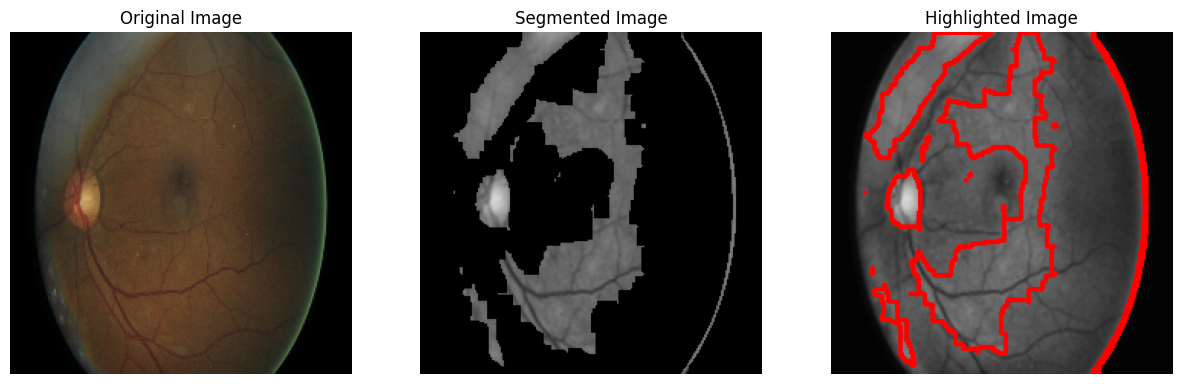

In [11]:
# Load the image
image = cv2.imread(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\colored_images\Moderate\1002_right.png")

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Convert the preprocessed image back to BGR format
preprocessed_bgr = cv2.cvtColor(preprocessed_image, cv2.COLOR_GRAY2BGR)

# Segment lesions directly from the preprocessed image
segmented_mask = segment_lesions(preprocessed_bgr)

# Convert the segmented mask to a single-channel binary image
segmented_mask_binary = cv2.cvtColor(segmented_mask, cv2.COLOR_BGR2GRAY)

# Highlight lesions
highlighted_image = highlight_lesions(preprocessed_image, segmented_mask_binary)

# Convert BGR image to RGB format for matplotlib
original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
segmented_rgb = cv2.cvtColor(segmented_mask, cv2.COLOR_BGR2RGB)
highlighted_rgb = cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB)

# Display all three images side by side
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_rgb)
plt.title('Original Image')
plt.axis('off')

# Segmented image
plt.subplot(1, 3, 2)
plt.imshow(segmented_rgb)
plt.title('Segmented Image')
plt.axis('off')

# Highlighted image
plt.subplot(1, 3, 3)
plt.imshow(highlighted_rgb)
plt.title('Highlighted Image')
plt.axis('off')

plt.show()


In [12]:
image.shape

(224, 224, 3)

# Create Csv

In [40]:
import os
import pandas as pd

# Specify the root directory where the images are located
root_dir = r'C:\Users\User\Downloads\archive (1)\colored_images\Cleaned Images'

# Define the severity levels
severity_levels = {
    'No_DR': 0,
    'Mild': 1,
    'Moderate': 2,
    'Severe': 3,
    'Proliferate_DR': 4
}

# Initialize lists to store image names and their corresponding levels
image_names = []
levels = []

# Iterate through each folder
for folder_name, severity_level in severity_levels.items():
    folder_path = os.path.join(root_dir, folder_name)
    # Iterate through each image in the folder
    for image_name in os.listdir(folder_path):
        image_names.append(image_name)
        levels.append(severity_level)

# Create a DataFrame
data = {'Image': image_names, 'Level': levels}
df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_path = r'C:\Users\User\Downloads\archive (1)\colored_images\data.csv' # Specify the path to save the CSV file
# Check if the CSV file already exists
if os.path.exists(csv_path):
    print("CSV file already exists.")
else:
    # Save DataFrame to CSV
    df.to_csv(csv_path, index=False)
    print("CSV file saved successfully.")


CSV file already exists.


In [15]:
pip install tensorflow-hub


     ---------------------------------------- 1.7/1.7 MB 5.8 MB/s eta 0:00:00


In [4]:
root_dir = r'C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images'
classes = os.listdir(root_dir)
classes

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [5]:
for dirpath, dirnames, filenames in os.walk(root_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath.split('/')[-1]}")

There are 5 directories and 0 images in C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images
There are 0 directories and 10000 images in C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Mild
There are 0 directories and 10000 images in C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Moderate
There are 0 directories and 10000 images in C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\No_DR
There are 0 directories and 10000 images in C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Proliferate_DR
There are 0 directories and 10000 images in C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Severe


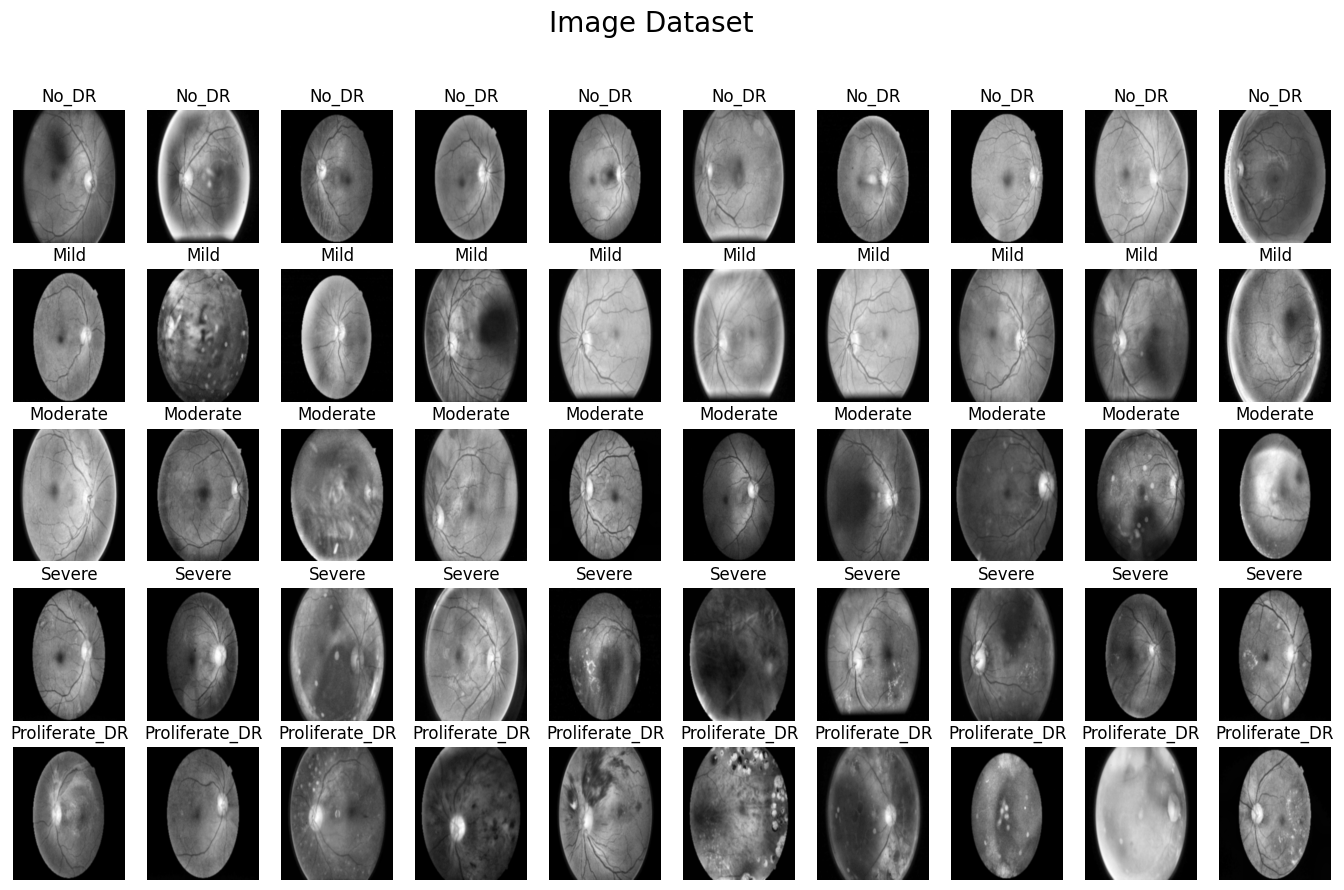

In [7]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_images(root_dir, classes):
    class_paths = [os.path.join(root_dir, image_class) for image_class in classes]

    images_path = []
    labels = []

    for class_path, label in zip(class_paths, classes):
        class_images = os.listdir(class_path)
        if len(class_images) >= 10:
            random_images = random.sample(class_images, 10)
        else:
            random_images = class_images
        random_images_path = [os.path.join(class_path, img) for img in random_images]
        images_path.extend(random_images_path)
        labels.extend([label] * len(random_images_path))

    plt.figure(figsize=(17, 10))
    plt.suptitle("Image Dataset", fontsize=20)

    for i, image_path in enumerate(images_path, 1):
        plt.subplot(5, 10, i)
        img = mpimg.imread(image_path)
        plt.imshow(img, cmap='gray', aspect="auto")
        plt.title(labels[i-1])
        plt.axis(False)

# Example usage:
root_dir =r'C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images'
classes = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]  # List of your class names
view_random_images(root_dir, classes)
plt.show()


In [6]:
import pandas as pd
train_csv = pd.read_csv(r'C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\data.csv')
train_csv

,Image,Level
0,10007_right.png,0
1,10009_right.png,0
2,1000_left.png,0
3,10010_left.png,0
4,10010_right.png,0
...,...,...
49995,copy995.png,4
49996,copy996.png,4
49997,copy997.png,4
49998,copy998.png,4


In [7]:
train_csv['Level'].value_counts()

Level
0    10000
1    10000
2    10000
3    10000
4    10000
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

# Concatenate the 'Image' and 'Level' columns to form your feature matrix X
X = train_csv[['Image', 'Level']]

# Split the data into training and testing sets
train_df, test_df = train_test_split(X, test_size=0.3, stratify=X['Level'], random_state=42)

# Reset the index of the dataframes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df



,Image,Level
0,copy8265.png,3
1,copy6425.png,4
2,copy2022.png,4
3,copy2239.png,4
4,20299_left.png,2
...,...,...
34995,11730_left.png,0
34996,copy7057.png,4
34997,2264_right.png,2
34998,copy1135.png,1


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file
train_csv = pd.read_csv(r'C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\data.csv')

# Calculate the number of images you want from each level
num_images_per_level = 3000

# Group the DataFrame by 'Level'
grouped = train_csv.groupby('Level')

# Initialize an empty DataFrame to store the sampled subset
sampled_df = pd.DataFrame()

# Iterate over each group (level) and sample 5000 images from each
for level, group_df in grouped:
    sampled_group = group_df.sample(n=num_images_per_level)
    sampled_df = pd.concat([sampled_df, sampled_group])

# Concatenate the 'Image' and 'Level' columns to form your feature matrix X
X = sampled_df[['Image', 'Level']]

# Split the data into training and testing sets
train_df, test_df = train_test_split(X, test_size=0.2, stratify=X['Level'], random_state=42)

# Reset the index of the dataframes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Now train_df and test_df contain only 5000 images from each level
train_df

,Image,Level
0,copy4989.png,4
1,44059_left.png,0
2,copy7016.png,3
3,copy4086.png,3
4,copy2849.png,3
...,...,...
11995,42811_right.png,0
11996,8504_right.png,2
11997,copy4128.png,1
11998,copy1423.png,1


In [9]:
# Check the number of images in each level in train_df
image_counts_per_level_train = train_df['Level'].value_counts()

print("Number of images in each level in train_df:")
print(image_counts_per_level_train)


Number of images in each level in train_df:
Level
3    7000
4    7000
2    7000
1    7000
0    7000
Name: count, dtype: int64


In [10]:
def mapping(df):
    class_code = {0: "No_DR",
                  1: "Mild", 
                  2: "Moderate",
                  3: "Severe",
                  4: "Proliferate_DR"}
    df['label'] = list(map(class_code.get, df['Level']))
    df['path'] = [i[1]['label']+'/'+i[1]['Image'] for i in df.iterrows()]
    return df


In [11]:
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.width', 10000)  # Adjust the width if necessary
mapping(train_df), mapping(test_df)

(                Image  Level           label                         path
 0        copy8265.png      3          Severe          Severe/copy8265.png
 1        copy6425.png      4  Proliferate_DR  Proliferate_DR/copy6425.png
 2        copy2022.png      4  Proliferate_DR  Proliferate_DR/copy2022.png
 3        copy2239.png      4  Proliferate_DR  Proliferate_DR/copy2239.png
 4      20299_left.png      2        Moderate      Moderate/20299_left.png
 ...               ...    ...             ...                          ...
 34995  11730_left.png      0           No_DR         No_DR/11730_left.png
 34996    copy7057.png      4  Proliferate_DR  Proliferate_DR/copy7057.png
 34997  2264_right.png      2        Moderate      Moderate/2264_right.png
 34998    copy1135.png      1            Mild            Mild/copy1135.png
 34999     copy679.png      4  Proliferate_DR   Proliferate_DR/copy679.png
 
 [35000 rows x 4 columns],
                  Image  Level           label                         

In [12]:
len(train_df), len(test_df)

(35000, 15000)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [14]:
# Initializing the input size
IMG_SHAPE = (224, 224)
N_SPLIT = 5
EPOCHS = 50 

In [15]:
# Defining euclidean distance function to be used as a evaluation metrics
def euclideanDist(img1, img2):
    return backend.sqrt(backend.sum((img1-img2)**2))

In [16]:
def validation_k_fold(model_test, k=5, epochs=EPOCHS, n_splits=N_SPLIT, lr=0.001): 
    kfold = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_y = train_df['label']
    train_x = train_df['path']

    histories = []
    model_test_results = []

    j = 0
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    for train_idx, val_idx in list(kfold.split(train_x, train_y)):
        x_train_df = train_df.iloc[train_idx]
        x_valid_df = train_df.iloc[val_idx]
        j += 1

        train_data = train_datagen.flow_from_dataframe(dataframe=x_train_df, 
                                                       directory=root_dir,
                                                       x_col='path',
                                                       y_col='label',
                                                       class_mode="categorical",
                                                       target_size=IMG_SHAPE,
                                                       batch_size=8)  # Set batch size to 32

        valid_data = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, 
                                                            directory=root_dir,
                                                            x_col='path',
                                                            y_col='label',
                                                            class_mode="categorical",
                                                            target_size=IMG_SHAPE,
                                                            batch_size=8)  # Set batch size to 32

        test_data = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                     directory=root_dir,
                                                     x_col='path',
                                                     y_col='label',
                                                     class_mode="categorical",
                                                     target_size=IMG_SHAPE,
                                                     batch_size=8)  # Set batch size to 32

        model_test.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adamax(learning_rate=lr),
                           metrics=[euclideanDist, 'accuracy', tf.keras.metrics.CosineSimilarity()])

        history = model_test.fit(train_data,
                                 validation_data=valid_data,
                                 epochs=epochs,
                                 callbacks=[es])

        result = model_test.evaluate(test_data)
        model_test_result = {
            "test_loss": result[0],
            "test_euclidean_dist": result[1],
            "test_accuracy": result[2],
            "test_cosine_similarity": result[3]
        }
        
        histories.append(history)
        model_test_results.append(model_test_result)

    return histories, model_test_results


In [25]:
# import numpy as np

# # Constants
# num_images = 50000
# image_height = 224
# image_width = 224
# num_channels = 3
# dtype_size = np.dtype(np.float32).itemsize  # Size of float32 in bytes

# # Memory required for one image in bytes
# image_memory = image_height * image_width * num_channels * dtype_size

# # Total memory required for the entire dataset
# total_dataset_memory = num_images * image_memory

# print("Memory required for one image:", image_memory, "bytes")
# print("Total memory required for the entire dataset:", total_dataset_memory / (1024 * 1024), "MiB")


Memory required for one image: 602112 bytes
Total memory required for the entire dataset: 28710.9375 MiB


In [10]:
# # Constants
# gpu_memory = 2048  # Available GPU memory in MiB
# model_memory = 100  # Estimated memory required for model parameters and activations in MiB
# gradient_memory = 100  # Estimated memory required for storing gradients during backpropagation in MiB

# # Additional memory overhead
# total_overhead_memory = model_memory + gradient_memory

# # Available memory for image data
# available_memory = gpu_memory - total_overhead_memory

# # Calculate the maximum batch size
# max_batch_size = available_memory // (image_memory / num_images)

# print("Maximum batch size:", max_batch_size)


Maximum batch size: 153.0


In [17]:
#Function to plot the performance metrics
def plot_result(hist):
    plt.figure(figsize=(10, 7));
    plt.suptitle(f"Performance Metrics", fontsize=20)
    
    # Actual and validation losses
    plt.subplot(2, 2, 1);
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title('Train and validation loss curve')
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(2, 2, 2);
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.title('Training and validation accuracy curve')
    plt.legend()

    # Actual and validation cosine similarity
    plt.subplot(2, 2, 3);
    plt.plot(hist.history['cosine_similarity'], label='train')
    plt.plot(hist.history['val_cosine_similarity'], label='validation')
    plt.title('Training and validation cosine_similarity curve')
    plt.legend()

    # Actual and validation euclidean distance
    plt.subplot(2, 2, 4);
    plt.plot(hist.history['euclideanDist'], label='train')
    plt.plot(hist.history['val_euclideanDist'], label='validation')
    plt.title('Training and validation euclidean distance curve')
    plt.legend()
    plt.tight_layout()

# CNN

In [21]:
# Define the input layer with the correct shape
input_layer = Input(shape=IMG_SHAPE + (3,))  # Assuming RGB images

# Define the CNN model with dropout layers
model_cnn = Sequential([
    input_layer,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the first max pooling layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the second max pooling layer
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Add dropout before the final dense layer
    Dense(5, activation='softmax')  # Assuming you have 5 classes
])
model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 54, 54, 64)       

In [22]:
model_cnn_history, model_cnn_result = validation_k_fold(model_cnn)

Found 28000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Epoch 1/50
1750/1750 [==============================] - 249s 136ms/step - loss: 1.6049 - euclideanDist: 3.5706 - accuracy: 0.2340 - cosine_similarity: 0.4512 - val_loss: 1.5828 - val_euclideanDist: 3.5509 - val_accuracy: 0.2680 - val_cosine_similarity: 0.4590
Epoch 2/50
1750/1750 [==============================] - 229s 131ms/step - loss: 1.5837 - euclideanDist: 3.5539 - accuracy: 0.2636 - cosine_similarity: 0.4587 - val_loss: 1.5707 - val_euclideanDist: 3.5397 - val_accuracy: 0.2866 - val_cosine_similarity: 0.4644
Epoch 3/50
1750/1750 [==============================] - 228s 131ms/step - loss: 1.5485 - euclideanDist: 3.5192 - accuracy: 0.2975 - cosine_similarity: 0.4739 - val_loss: 1.4819 - val_euclideanDist: 3.4522 - val_accuracy: 0.3450 - val_cosine_similarity: 0.5006
Epoch 4/50
1750/1750 [=============

In [25]:
# Save the model
import pickle
model_cnn.save(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_cnn2.keras")

# Save the evaluation results
with open(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_cnn2.pkl", 'wb') as f:
    pickle.dump(model_cnn_result, f)


In [23]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_cnn_history):
    # Get the validation accuracy of the last epoch
    val_accuracy = fold_history.history['val_accuracy'][-1]
    print(f"Fold {i+1} - Accuracy: {val_accuracy}")


Fold 1 - Accuracy: 0.836571455001831
Fold 2 - Accuracy: 0.9789999723434448
Fold 3 - Accuracy: 0.9774285554885864
Fold 4 - Accuracy: 0.9942857027053833
Fold 5 - Accuracy: 0.9904285669326782


In [24]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_val_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_cnn_history):
    # Get the validation accuracy of the last epoch
    val_accuracy = fold_history.history['val_accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best Accuracy: {best_val_accuracy}")


Best Accuracy: 0.9942857027053833


In [23]:
# Evaluation metrics for cnn
model_cnn_result

[{'test_loss': 0.40326988697052,
  'test_euclidean_dist': 0.8795999884605408,
  'test_accuracy': 0.896392822265625,
  'test_cosine_similarity': 2.3357691764831543},
 {'test_loss': 0.3570708930492401,
  'test_euclidean_dist': 0.9005333185195923,
  'test_accuracy': 0.914256751537323,
  'test_cosine_similarity': 2.105482578277588},
 {'test_loss': 0.37650570273399353,
  'test_euclidean_dist': 0.9062666893005371,
  'test_accuracy': 0.9180744886398315,
  'test_cosine_similarity': 2.077004909515381},
 {'test_loss': 0.3701748847961426,
  'test_euclidean_dist': 0.9036666750907898,
  'test_accuracy': 0.9180631637573242,
  'test_cosine_similarity': 2.0622355937957764},
 {'test_loss': 0.44200924038887024,
  'test_euclidean_dist': 0.9087333083152771,
  'test_accuracy': 0.9185922145843506,
  'test_cosine_similarity': 2.074800491333008}]

In [26]:
# Find the maximum test accuracy among the folds
best_accuracy = max(result['test_accuracy'] for result in model_cnn_result)

# Print the best model accuracy
print("Best test accuracy:", best_accuracy)

Best test accuracy: 0.9185922145843506


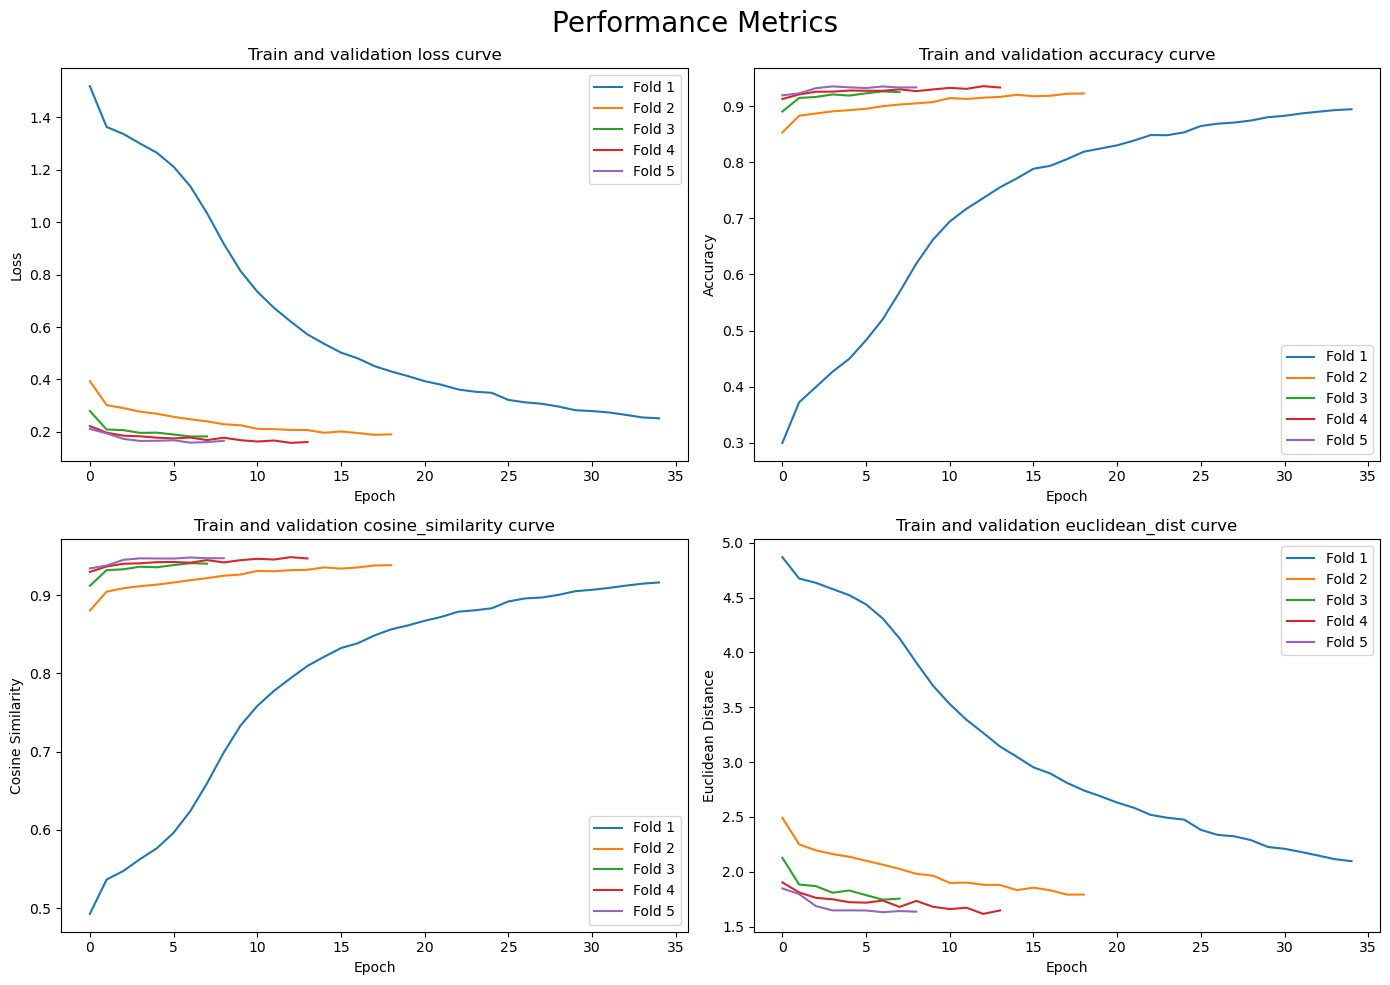

In [35]:

import matplotlib.pyplot as plt

def plot_result(histories):
    plt.figure(figsize=(14, 10))
    plt.suptitle("Performance Metrics", fontsize=20)
    
    metrics = ['loss', 'accuracy', 'cosine_similarity', 'euclidean_dist']
    metric_titles = ['Loss', 'Accuracy', 'Cosine Similarity', 'Euclidean Distance']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        for j, hist in enumerate(histories):
            plt.plot(hist.history[metric], label=f'Fold {j+1}')
        plt.title(f'Train and validation {metric} curve')
        plt.xlabel('Epoch')
        plt.ylabel(metric_titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the performance metrics for each fold
plot_result(model_cnn_history)


## Preduction

In [42]:
def predict_retinopathy_level(image_array):
    # Load the trained machine learning model
    model = tf.keras.models.load_model(
        r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_cnn2.keras", custom_objects={'euclideanDist': euclideanDist})

    # Make prediction using the loaded model
    prediction = model.predict(image_array)

    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]

    # Define default message
    message = ""

    # Define informative message based on predicted retinopathy level
    if predicted_class == 'No_DR':
        message = "😊 No Diabetic Retinopathy (NO DR): At this stage, there are typically no signs of retinal damage or abnormalities observed upon examination."
    elif predicted_class == 'Mild':
        message = "😐 Mild Nonproliferative DR: In this stage, small areas of balloon-like swelling in the tiny blood vessels of the retina (microaneurysms) may start to develop."
    elif predicted_class == 'Moderate':
        message = "😟 Moderate Nonproliferative DR: Microaneurysms are more numerous and may be slightly enlarged."
    elif predicted_class == 'Severe':
        message = "😧 Severe Nonproliferative DR: At this stage, there is a significant increase in the number and size of retinal hemorrhages."
    elif predicted_class == 'Proliferate_DR':
        message = "😨 Proliferative DR: This is the most advanced stage of diabetic retinopathy."

    return predicted_class, message

In [43]:
# Define the function with @tf.function decorator outside of the loop
@tf.function
def my_function(input_tensor):
    return tf.square(input_tensor)

# Define the input tensor outside of the loop
input_tensor = tf.constant(2.0)

# Call the function inside the loop
for i in range(5):
    result = my_function(input_tensor)
    print(result)

tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)


In [42]:
from tensorflow.keras.preprocessing import image
# Load and preprocess the image
img_path = r"C:\Users\User\Downloads\archive (1)\colored_images\Cleaned Images\No_DR\102_right.png"
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
predicted_class, message = predict_retinopathy_level(img_array)

print("Predicted class:", predicted_class)
print("Message:", message)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted class: No_DR
Message: 😊 No Diabetic Retinopathy (NO DR): At this stage, there are typically no signs of retinal damage or abnormalities observed upon examination.


In [40]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\User\Downloads\archive (1)\colored_images\Cleaned Images\Proliferate_DR\16_left.png"
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
predicted_class, message = predict_retinopathy_level(img_array)

print("Predicted class:", predicted_class)
print("Message:", message)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Predicted class: Proliferate_DR
Message: 😨 Proliferative DR: This is the most advanced stage of diabetic retinopathy.


In [37]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Mild\36_left.png"
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
predicted_class, message = predict_retinopathy_level(img_array)

print("Predicted class:", predicted_class)
print("Message:", message)

1/1 [==============================] - 1s 575ms/step
Predicted class: Mild
Message: 😐 Mild Nonproliferative DR: In this stage, small areas of balloon-like swelling in the tiny blood vessels of the retina (microaneurysms) may start to develop.


In [38]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Severe\2016_right.png"
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
predicted_class, message = predict_retinopathy_level(img_array)

print("Predicted class:", predicted_class)
print("Message:", message)

1/1 [==============================] - 0s 52ms/step
Predicted class: Severe
Message: 😧 Severe Nonproliferative DR: At this stage, there is a significant increase in the number and size of retinal hemorrhages.


In [47]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"D:\archive (1)\diabetic-retinopathy-customized\resized_train_cropped\Cleaned Images\Proliferate_DR\2916_left.jpeg"
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
predicted_class, message = predict_retinopathy_level(img_array)

print("Predicted class:", predicted_class)
print("Message:", message)

1/1 [==============================] - 0s 205ms/step
Predicted class: No_DR
Message: 😊 No Diabetic Retinopathy (NO DR): At this stage, there are typically no signs of retinal damage or abnormalities observed upon examination.


# Xception

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception

# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE + (3,))

# Freeze convolutional layers except for the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)  # num_classes is the number of classes in your dataset

# Create the model
model_Xception = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_Xception.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_Xception.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [20]:
model_Xception_history, model_Xception_result = validation_k_fold(model_Xception)

Found 16000 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.
Found 5000 validated image filenames belonging to 5 classes.
Epoch 1/50
1000/1000 [==============================] - 336s 328ms/step - loss: 1.2268 - euclideanDist: 3.1923 - accuracy: 0.4524 - cosine_similarity: 0.5875 - val_loss: 1.6154 - val_euclideanDist: 3.5221 - val_accuracy: 0.3787 - val_cosine_similarity: 0.5063
Epoch 2/50
1000/1000 [==============================] - 331s 331ms/step - loss: 0.9916 - euclideanDist: 2.9114 - accuracy: 0.5581 - cosine_similarity: 0.6648 - val_loss: 1.3406 - val_euclideanDist: 3.2214 - val_accuracy: 0.4807 - val_cosine_similarity: 0.5806
Epoch 3/50
1000/1000 [==============================] - 335s 335ms/step - loss: 0.7942 - euclideanDist: 2.6372 - accuracy: 0.6457 - cosine_similarity: 0.7290 - val_loss: 0.8205 - val_euclideanDist: 2.6702 - val_accuracy: 0.6323 - val_cosine_similarity: 0.7217
Epoch 4/50
1000/1000 [==============

In [35]:
# Save the model
#model_alexnet.save(r"C:\Users\User\Downloads\archive (1)\colored_images\model_alexnet.h5")
# Save the model
import pickle
model_Xception.save(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_Xception.keras")

# Save the evaluation results
with open(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_Xception.pkl", 'wb') as f:
    pickle.dump(model_Xception_result, f)


In [27]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_Xception_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    print(f"Fold {i+1} - Accuracy: {accuracy}")


Fold 1 - Accuracy: 0.948312520980835
Fold 2 - Accuracy: 0.9834374785423279
Fold 3 - Accuracy: 0.9929999709129333
Fold 4 - Accuracy: 0.9955624938011169
Fold 5 - Accuracy: 0.9965000152587891


In [30]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_Xception_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best  Accuracy: {best_accuracy}")


Best  Accuracy: 0.9965000152587891


In [21]:
# Evaluation metrics for alexnet
model_Xception_result


[{'test_loss': 0.9705090522766113,
  'test_euclidean_dist': 2.367191791534424,
  'test_accuracy': 0.770799994468689,
  'test_cosine_similarity': 0.7960911393165588},
 {'test_loss': 0.9263990521430969,
  'test_euclidean_dist': 2.1983273029327393,
  'test_accuracy': 0.8022000193595886,
  'test_cosine_similarity': 0.820107102394104},
 {'test_loss': 1.1783045530319214,
  'test_euclidean_dist': 2.2074432373046875,
  'test_accuracy': 0.8108000159263611,
  'test_cosine_similarity': 0.8238858580589294},
 {'test_loss': 1.3703985214233398,
  'test_euclidean_dist': 2.2036705017089844,
  'test_accuracy': 0.8127999901771545,
  'test_cosine_similarity': 0.824375569820404},
 {'test_loss': 1.3483779430389404,
  'test_euclidean_dist': 2.142435073852539,
  'test_accuracy': 0.8187999725341797,
  'test_cosine_similarity': 0.8301210999488831}]

In [33]:
# Find the maximum test accuracy among the folds
best_accuracy = max(result['test_accuracy'] for result in model_Xception_result)

# Print the best model accuracy
print("Best Model Test Accuracy:", best_accuracy)

Best Model Test Accuracy: 0.8187999725341797


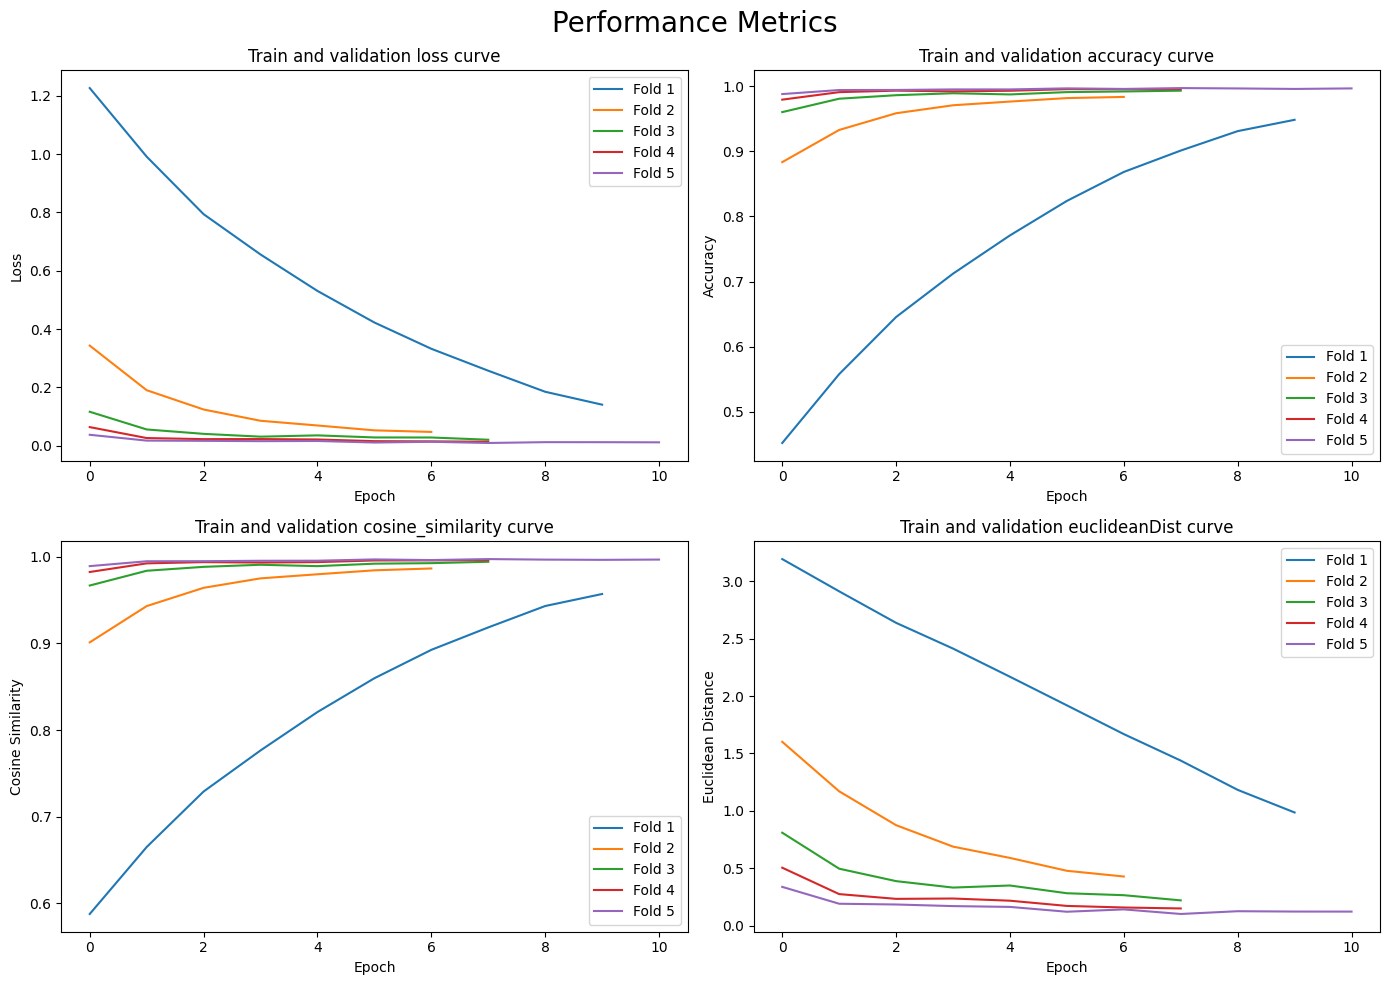

In [39]:

import matplotlib.pyplot as plt

def plot_result(histories):
    plt.figure(figsize=(14, 10))
    plt.suptitle("Performance Metrics", fontsize=20)
    
    metrics = ['loss', 'accuracy', 'cosine_similarity', 'euclideanDist']
    metric_titles = ['Loss', 'Accuracy', 'Cosine Similarity', 'Euclidean Distance']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        for j, hist in enumerate(histories):
            plt.plot(hist.history[metric], label=f'Fold {j+1}')
        plt.title(f'Train and validation {metric} curve')
        plt.xlabel('Epoch')
        plt.ylabel(metric_titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the performance metrics for each fold
plot_result(model_Xception_history)


## Prediction

In [41]:
def predict_retinopathy_level(image_array):
    # Load the trained machine learning model
    model = tf.keras.models.load_model(
        r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_Xception.keras", custom_objects={'euclideanDist': euclideanDist})

    # Make prediction using the loaded model
    prediction = model.predict(image_array)

    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]

    # Define default message
    message = ""

    # Define informative message based on predicted retinopathy level
    if predicted_class == 'No_DR':
        message = "😊 No Diabetic Retinopathy (NO DR): At this stage, there are typically no signs of retinal damage or abnormalities observed upon examination."
    elif predicted_class == 'Mild':
        message = "😐 Mild Nonproliferative DR: In this stage, small areas of balloon-like swelling in the tiny blood vessels of the retina (microaneurysms) may start to develop."
    elif predicted_class == 'Moderate':
        message = "😟 Moderate Nonproliferative DR: Microaneurysms are more numerous and may be slightly enlarged."
    elif predicted_class == 'Severe':
        message = "😧 Severe Nonproliferative DR: At this stage, there is a significant increase in the number and size of retinal hemorrhages."
    elif predicted_class == 'Proliferate_DR':
        message = "😨 Proliferative DR: This is the most advanced stage of diabetic retinopathy."

    return predicted_class, message

In [43]:
from tensorflow.keras.preprocessing import image
# Load and preprocess the image
img_path = r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Moderate\15_right.png"
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
predicted_class, message = predict_retinopathy_level(img_array)

print("Predicted class:", predicted_class)
print("Message:", message)

1/1 [==============================] - 3s 3s/step
Predicted class: Moderate
Message: 😟 Moderate Nonproliferative DR: Microaneurysms are more numerous and may be slightly enlarged.


# Alex Net

In [18]:
# Basic CNN model for AlexNet
model_alexnet = tf.keras.Sequential([
    Input(shape=IMG_SHAPE + (3,)),  # Use Input(shape) instead of passing input_shape directly
    Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
    MaxPool2D(pool_size=3, strides=2),
    Dropout(0.25),
    Conv2D(filters=256, kernel_size=5, strides=1, padding='valid', activation='relu'),
    MaxPool2D(pool_size=3, strides=2),
    Dropout(0.25),
    Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation='relu'),
    Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
], name="model_AlexNet")
model_alexnet.summary()

Model: "model_AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 26, 26, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 256)     

In [19]:
model_alexnet_history, model_alexnet_result = validation_k_fold(model_alexnet)

Found 28000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Epoch 1/50
3500/3500 [==============================] - 251s 69ms/step - loss: 1.6065 - euclideanDist: 2.5277 - accuracy: 0.2158 - cosine_similarity: 0.4487 - val_loss: 1.5980 - val_euclideanDist: 2.5225 - val_accuracy: 0.2550 - val_cosine_similarity: 0.4521
Epoch 2/50
3500/3500 [==============================] - 241s 69ms/step - loss: 1.5972 - euclideanDist: 2.5215 - accuracy: 0.2404 - cosine_similarity: 0.4529 - val_loss: 1.5865 - val_euclideanDist: 2.5138 - val_accuracy: 0.2547 - val_cosine_similarity: 0.4577
Epoch 3/50
3500/3500 [==============================] - 239s 68ms/step - loss: 1.5903 - euclideanDist: 2.5165 - accuracy: 0.2537 - cosine_similarity: 0.4561 - val_loss: 1.5829 - val_euclideanDist: 2.5119 - val_accuracy: 0.2477 - val_cosine_similarity: 0.4589
Epoch 4/50
3500/3500 [================

In [29]:
# Save the model
#model_alexnet.save(r"C:\Users\User\Downloads\archive (1)\colored_images\model_alexnet.h5")
# Save the model
import pickle
model_alexnet.save(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_alexnet.keras")

# Save the evaluation results
with open(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_alexnet.pkl", 'wb') as f:
    pickle.dump(model_alexnet_result, f)


In [22]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_alexnet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    print(f"Fold {i+1} - Accuracy: {accuracy}")


Fold 1 - Accuracy: 0.9013928771018982
Fold 2 - Accuracy: 0.9070714116096497
Fold 3 - Accuracy: 0.9255714416503906
Fold 4 - Accuracy: 0.9447857141494751
Fold 5 - Accuracy: 0.9484285712242126


In [24]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_alexnet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best  Accuracy: {best_accuracy}")


Best  Accuracy: 0.9484285712242126


In [27]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_alexnet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    print(f"Fold {i+1} - Val Accuracy: {accuracy}")


Fold 1 - Val Accuracy: 0.7429999709129333
Fold 2 - Val Accuracy: 0.8638571500778198
Fold 3 - Val Accuracy: 0.8602856993675232
Fold 4 - Val Accuracy: 0.8287143111228943
Fold 5 - Val Accuracy: 0.8921428322792053


In [28]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_alexnet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best val_ Accuracy: {best_accuracy}")


Best val_ Accuracy: 0.8921428322792053


In [20]:
# Evaluation metrics for alexnet
model_alexnet_result

[{'test_loss': 0.696713924407959,
  'test_euclidean_dist': 1.62772798538208,
  'test_accuracy': 0.739799976348877,
  'test_cosine_similarity': 0.7882061004638672},
 {'test_loss': 0.5806082487106323,
  'test_euclidean_dist': 1.5095168352127075,
  'test_accuracy': 0.7771999835968018,
  'test_cosine_similarity': 0.8188466429710388},
 {'test_loss': 0.620915412902832,
  'test_euclidean_dist': 1.5342990159988403,
  'test_accuracy': 0.7717333436012268,
  'test_cosine_similarity': 0.8115339279174805},
 {'test_loss': 0.7653045654296875,
  'test_euclidean_dist': 1.642637014389038,
  'test_accuracy': 0.7456666827201843,
  'test_cosine_similarity': 0.7865906953811646},
 {'test_loss': 0.6722248792648315,
  'test_euclidean_dist': 1.5160062313079834,
  'test_accuracy': 0.7815999984741211,
  'test_cosine_similarity': 0.8151180744171143}]

In [26]:
# Find the maximum test accuracy among the folds
best_accuracy = max(result['test_accuracy'] for result in model_alexnet_result)

# Print the best model accuracy
print("Best Test Accuracy:", best_accuracy)

Best Test Accuracy: 0.7815999984741211


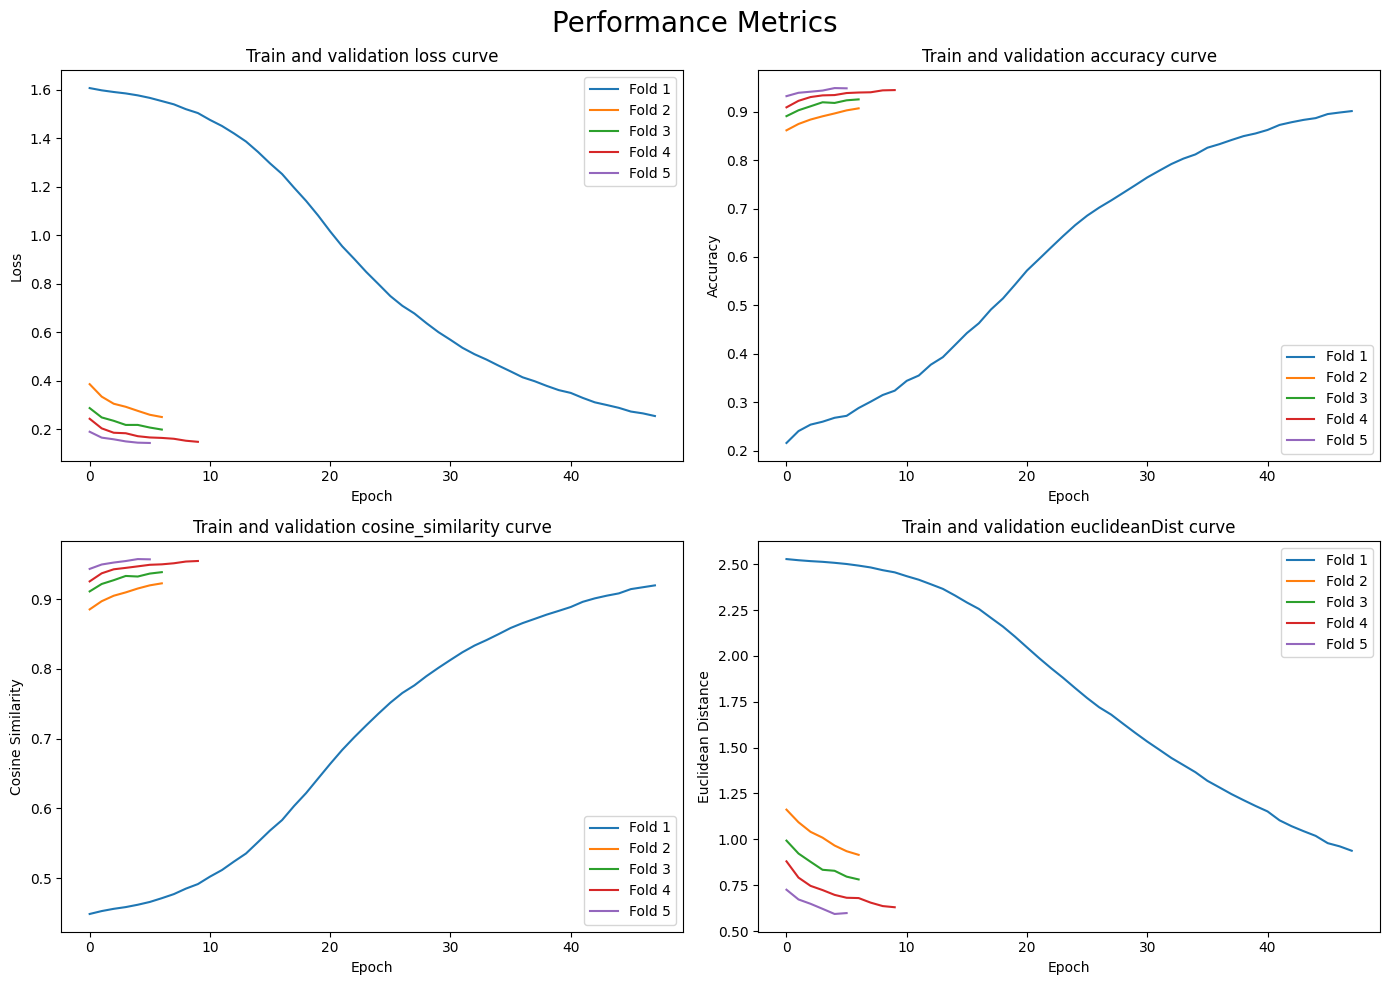

In [30]:

import matplotlib.pyplot as plt

def plot_result(histories):
    plt.figure(figsize=(14, 10))
    plt.suptitle("Performance Metrics", fontsize=20)
    
    metrics = ['loss', 'accuracy', 'cosine_similarity', 'euclideanDist']
    metric_titles = ['Loss', 'Accuracy', 'Cosine Similarity', 'Euclidean Distance']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        for j, hist in enumerate(histories):
            plt.plot(hist.history[metric], label=f'Fold {j+1}')
        plt.title(f'Train and validation {metric} curve')
        plt.xlabel('Epoch')
        plt.ylabel(metric_titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the performance metrics for each fold
plot_result(model_alexnet_history)


#  Inception v3

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE + (3,))

# Freeze convolutional layers except for the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)  # num_classes is the number of classes in your dataset

# Create the model
model_inception = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_inception.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_inception.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [29]:
model_inception_history, model_inception_result = validation_k_fold(model_inception)

Found 28000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Epoch 1/50
3500/3500 [==============================] - 379s 103ms/step - loss: 1.4000 - euclideanDist: 2.3825 - accuracy: 0.3723 - cosine_similarity: 0.5296 - val_loss: 1.2988 - val_euclideanDist: 2.3162 - val_accuracy: 0.4129 - val_cosine_similarity: 0.5614
Epoch 2/50
3500/3500 [==============================] - 348s 99ms/step - loss: 1.2967 - euclideanDist: 2.3108 - accuracy: 0.4140 - cosine_similarity: 0.5628 - val_loss: 1.2241 - val_euclideanDist: 2.2558 - val_accuracy: 0.4491 - val_cosine_similarity: 0.5861
Epoch 3/50
3500/3500 [==============================] - 345s 99ms/step - loss: 1.2395 - euclideanDist: 2.2670 - accuracy: 0.4408 - cosine_similarity: 0.5815 - val_loss: 1.1756 - val_euclideanDist: 2.2107 - val_accuracy: 0.4643 - val_cosine_similarity: 0.6046
Epoch 4/50
3500/3500 [===============

In [37]:
# Save the model
#model_alexnet.save(r"C:\Users\User\Downloads\archive (1)\colored_images\model_alexnet.h5")
# Save the model
import pickle
model_inception.save(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_inception.keras")

# Save the evaluation results
with open(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_inception.pkl", 'wb') as f:
    pickle.dump(model_inception_result, f)


In [32]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_inception_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    print(f"Fold {i+1} - Accuracy: {accuracy}")


Fold 1 - Accuracy: 0.7697142958641052
Fold 2 - Accuracy: 0.8655714392662048
Fold 3 - Accuracy: 0.8980000019073486
Fold 4 - Accuracy: 0.9128571152687073
Fold 5 - Accuracy: 0.927142858505249


In [35]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_inception_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best  Accuracy: {best_accuracy}")


Best  Accuracy: 0.927142858505249


In [30]:
model_inception_result

[{'test_loss': 0.5789139270782471,
  'test_euclidean_dist': 1.5280249118804932,
  'test_accuracy': 0.7635999917984009,
  'test_cosine_similarity': 0.8137529492378235},
 {'test_loss': 0.5143728256225586,
  'test_euclidean_dist': 1.449866771697998,
  'test_accuracy': 0.790066659450531,
  'test_cosine_similarity': 0.8334046006202698},
 {'test_loss': 0.507804811000824,
  'test_euclidean_dist': 1.4083601236343384,
  'test_accuracy': 0.8011333346366882,
  'test_cosine_similarity': 0.8400377035140991},
 {'test_loss': 0.47789013385772705,
  'test_euclidean_dist': 1.3549835681915283,
  'test_accuracy': 0.8149999976158142,
  'test_cosine_similarity': 0.8510221838951111},
 {'test_loss': 0.4942867159843445,
  'test_euclidean_dist': 1.3473340272903442,
  'test_accuracy': 0.819599986076355,
  'test_cosine_similarity': 0.8532848358154297}]

In [36]:
# Find the maximum test accuracy among the folds
best_accuracy = max(result['test_accuracy'] for result in model_inception_result)

# Print the best model accuracy
print("Best  Test Accuracy:", best_accuracy)

Best  Test Accuracy: 0.819599986076355


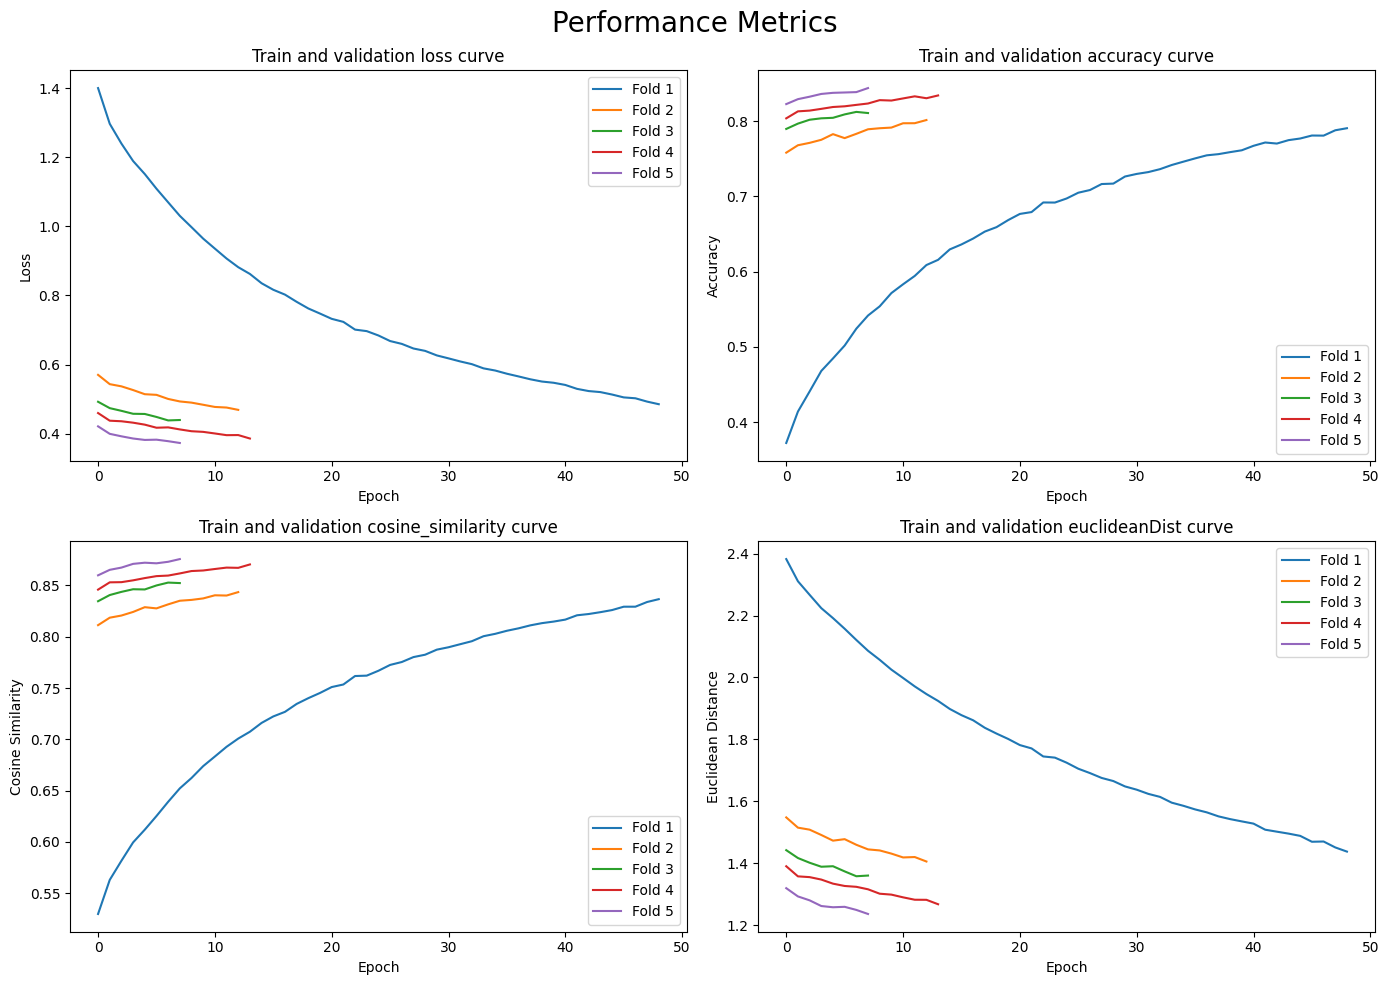

In [38]:

import matplotlib.pyplot as plt

def plot_result(histories):
    plt.figure(figsize=(14, 10))
    plt.suptitle("Performance Metrics", fontsize=20)
    
    metrics = ['loss', 'accuracy', 'cosine_similarity', 'euclideanDist']
    metric_titles = ['Loss', 'Accuracy', 'Cosine Similarity', 'Euclidean Distance']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        for j, hist in enumerate(histories):
            plt.plot(hist.history[metric], label=f'Fold {j+1}')
        plt.title(f'Train and validation {metric} curve')
        plt.xlabel('Epoch')
        plt.ylabel(metric_titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the performance metrics for each fold
plot_result(model_inception_history)


In [53]:
def predict_retinopathy_level(image_array):
    # Load the trained machine learning model
    model = tf.keras.models.load_model(r"C:\Users\User\Downloads\archive (1)\colored_images\model_inception.keras")

    # Make prediction using the loaded model
    prediction = model.predict(image_array)

    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]  # Assuming you have defined the classes list
    
    # Define informative message based on predicted retinopathy level
    if predicted_class == 'NO DR':
        message = "😊 No Diabetic Retinopathy (NO DR): At this stage, there are typically no signs of retinal damage or abnormalities observed upon examination."
    elif predicted_class == 'MILD':
        message = "😐 Mild Nonproliferative DR: In this stage, small areas of balloon-like swelling in the tiny blood vessels of the retina (microaneurysms) may start to develop."
    elif predicted_class == 'MODERATE':
        message = "😟 Moderate Nonproliferative DR: Microaneurysms are more numerous and may be slightly enlarged."
    elif predicted_class == 'SEVERE':
        message = "😧 Severe Nonproliferative DR: At this stage, there is a significant increase in the number and size of retinal hemorrhages."
    elif predicted_class == 'PROLIFERATE':
        message = "😨 Proliferative DR: This is the most advanced stage of diabetic retinopathy."

    return predicted_class, message


## ResNet50

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add

def conv_block(x, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters, kernel_size):
    x_res = x
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_res, x])
    x = Activation('relu')(x)
    return x

def resnet34(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 64, 7, strides=(2, 2))
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    x = conv_block(x, 64, 3)
    x = conv_block(x, 64, 3)
    x = identity_block(x, 64, 3)
    
    x = conv_block(x, 128, 3, strides=(2, 2))
    x = conv_block(x, 128, 3)
    x = identity_block(x, 128, 3)
    x = identity_block(x, 128, 3)
    
    x = conv_block(x, 256, 3, strides=(2, 2))
    x = conv_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    
    x = conv_block(x, 512, 3, strides=(2, 2))
    x = conv_block(x, 512, 3)
    x = identity_block(x, 512, 3)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Example usage:
input_shape = (224, 224, 3)
num_classes = 5  # Example number of classes
model_resnet34 = resnet34(input_shape, num_classes)
model_resnet34.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
model_resnet34_history, model_resnet34_result = validation_k_fold(model_resnet34)                                                    

Found 28000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Epoch 1/50
3500/3500 [==============================] - 893s 251ms/step - loss: 1.6359 - euclideanDist: 2.5442 - accuracy: 0.2104 - cosine_similarity: 0.4384 - val_loss: 1.6704 - val_euclideanDist: 2.5587 - val_accuracy: 0.2004 - val_cosine_similarity: 0.4318
Epoch 2/50
3500/3500 [==============================] - 874s 250ms/step - loss: 1.6192 - euclideanDist: 2.5351 - accuracy: 0.2182 - cosine_similarity: 0.4438 - val_loss: 6.7413 - val_euclideanDist: 3.0355 - val_accuracy: 0.2047 - val_cosine_similarity: 0.3041
Epoch 3/50
3500/3500 [==============================] - 851s 243ms/step - loss: 1.5633 - euclideanDist: 2.4981 - accuracy: 0.2792 - cosine_similarity: 0.4672 - val_loss: 1.6346 - val_euclideanDist: 2.5540 - val_accuracy: 0.2386 - val_cosine_similarity: 0.4347
Epoch 4/50
3500/3500 [=============

In [25]:
# Save the model
#model_alexnet.save(r"C:\Users\User\Downloads\archive (1)\colored_images\model_alexnet.h5")
# Save the model
import pickle
model_resnet34.save(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_resnet.keras")

# Save the evaluation results
with open(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_resnett.pkl", 'wb') as f:
    pickle.dump(model_resnet34_result, f)


In [27]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_resnet34_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    print(f"Fold {i+1} - Accuracy: {accuracy}")


Fold 1 - Accuracy: 0.9545000195503235
Fold 2 - Accuracy: 0.9887857437133789
Fold 3 - Accuracy: 0.9912499785423279
Fold 4 - Accuracy: 0.9942499995231628
Fold 5 - Accuracy: 0.9966785907745361


In [30]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_resnet34_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best  Accuracy: {best_accuracy}")


Best  Accuracy: 0.9966785907745361


In [32]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_resnet34_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    print(f"Fold {i+1} - Val Accuracy: {accuracy}")


Fold 1 - Val Accuracy: 0.6980000138282776
Fold 2 - Val Accuracy: 0.9462857246398926
Fold 3 - Val Accuracy: 0.9648571610450745
Fold 4 - Val Accuracy: 0.9901428818702698
Fold 5 - Val Accuracy: 0.9978571534156799


In [33]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_resnet34_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best Val Accuracy: {best_accuracy}")


Best Val Accuracy: 0.9978571534156799


In [35]:
# Evaluation metrics for resNet
model_resnet34_result

[{'test_loss': 1.0942248106002808,
  'test_euclidean_dist': 1.8558014631271362,
  'test_accuracy': 0.6952666640281677,
  'test_cosine_similarity': 0.7365800142288208},
 {'test_loss': 0.7770829200744629,
  'test_euclidean_dist': 1.2721787691116333,
  'test_accuracy': 0.8388000130653381,
  'test_cosine_similarity': 0.8543218374252319},
 {'test_loss': 0.7916946411132812,
  'test_euclidean_dist': 1.0846644639968872,
  'test_accuracy': 0.876466691493988,
  'test_cosine_similarity': 0.8868300914764404},
 {'test_loss': 0.8589545488357544,
  'test_euclidean_dist': 1.2020496129989624,
  'test_accuracy': 0.8543333411216736,
  'test_cosine_similarity': 0.8659179210662842},
 {'test_loss': 0.8949311375617981,
  'test_euclidean_dist': 1.1916358470916748,
  'test_accuracy': 0.8561333417892456,
  'test_cosine_similarity': 0.8663963079452515}]

In [34]:
# Find the maximum test accuracy among the folds
best_accuracy = max(result['test_accuracy'] for result in model_resnet34_result)

# Print the best model accuracy
print("Best  Test Accuracy:", best_accuracy)

Best  Test Accuracy: 0.876466691493988


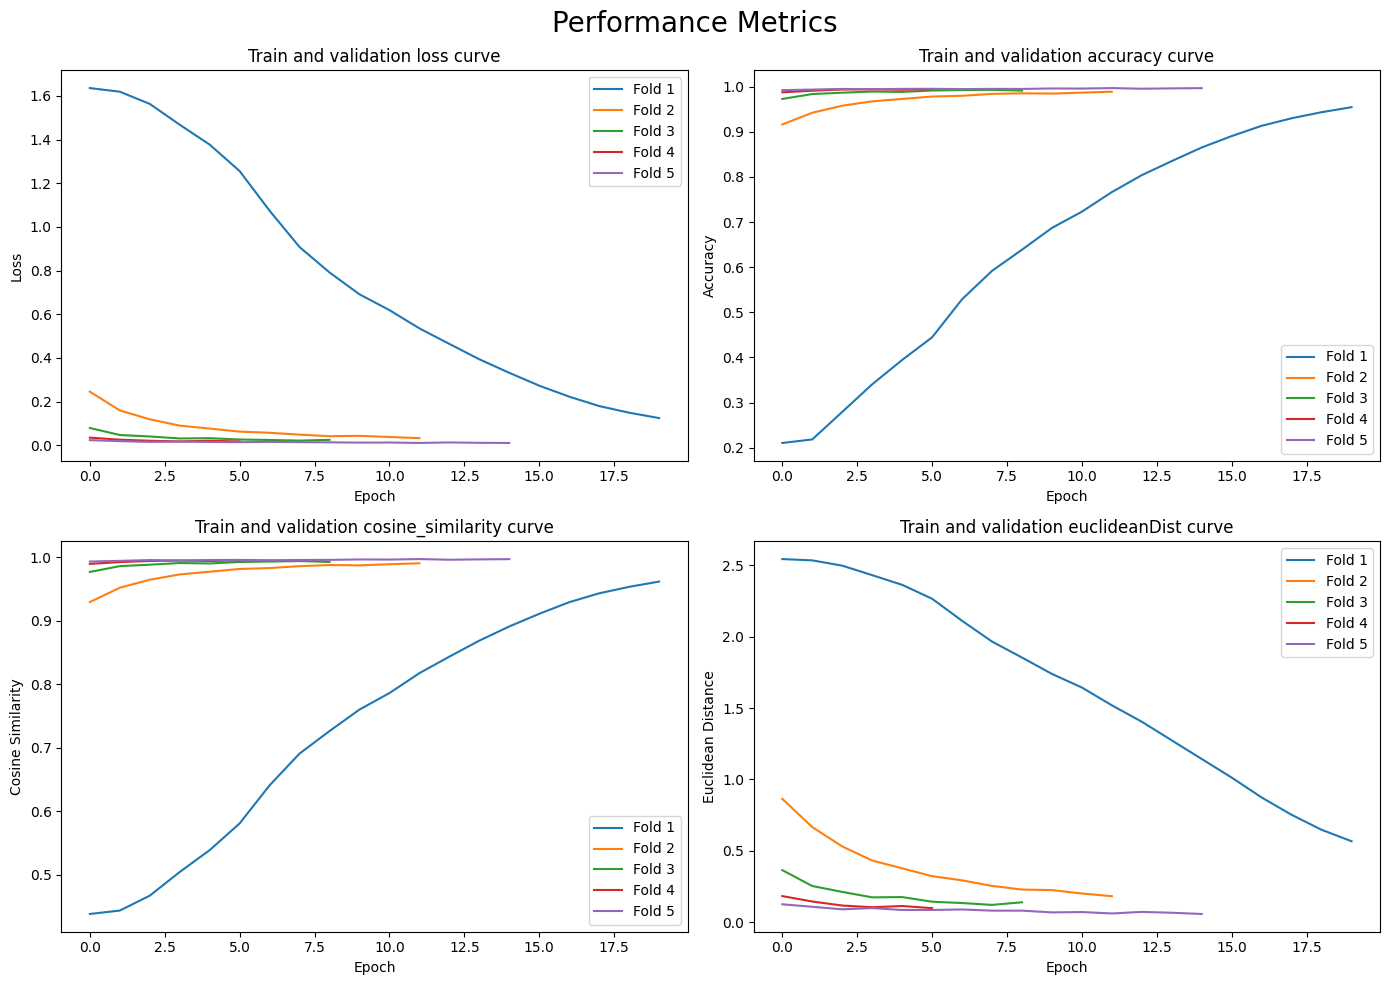

In [37]:

import matplotlib.pyplot as plt

def plot_result(histories):
    plt.figure(figsize=(14, 10))
    plt.suptitle("Performance Metrics", fontsize=20)
    
    metrics = ['loss', 'accuracy', 'cosine_similarity', 'euclideanDist']
    metric_titles = ['Loss', 'Accuracy', 'Cosine Similarity', 'Euclidean Distance']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        for j, hist in enumerate(histories):
            plt.plot(hist.history[metric], label=f'Fold {j+1}')
        plt.title(f'Train and validation {metric} curve')
        plt.xlabel('Epoch')
        plt.ylabel(metric_titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the performance metrics for each fold
plot_result(model_resnet34_history)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
loaded_model = tf.keras.models.load_model(r"C:\Users\User\Downloads\archive (1)\colored_images\model_inception.h5")

# Load and preprocess the image
img_path = "path/to/your/image.jpg"  # Replace with the path to your image
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
prediction = loaded_model.predict(img_array)

# Get the predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class = classes[predicted_class_index]

print("Predicted class:", predicted_class)


# MobileNetV2

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Clear GPU memory
tf.keras.backend.clear_session()

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Create the model
model_mobilenet = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Print model summary
model_mobilenet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [20]:
# Validate the model using k-fold cross-validation
model_mobilenet_history, model_mobilenet_result = validation_k_fold(model_mobilenet)

Found 28000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Epoch 1/50
3500/3500 [==============================] - 583s 164ms/step - loss: 1.1345 - euclideanDist: 2.1771 - accuracy: 0.4942 - cosine_similarity: 0.6173 - val_loss: 1.8357 - val_euclideanDist: 2.4792 - val_accuracy: 0.4549 - val_cosine_similarity: 0.5341
Epoch 2/50
3500/3500 [==============================] - 579s 165ms/step - loss: 0.8123 - euclideanDist: 1.8815 - accuracy: 0.6275 - cosine_similarity: 0.7200 - val_loss: 1.0513 - val_euclideanDist: 2.0029 - val_accuracy: 0.6103 - val_cosine_similarity: 0.6864
Epoch 3/50
3500/3500 [==============================] - 573s 164ms/step - loss: 0.6478 - euclideanDist: 1.6871 - accuracy: 0.7121 - cosine_similarity: 0.7774 - val_loss: 0.7006 - val_euclideanDist: 1.7232 - val_accuracy: 0.6970 - val_cosine_similarity: 0.7624
Epoch 4/50
3500/3500 [=============

In [21]:
# Save the model
#model_alexnet.save(r"C:\Users\User\Downloads\archive (1)\colored_images\model_alexnet.h5")
# Save the model
import pickle
model_mobilenet.save(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_mobilenet.keras")

# Save the evaluation results
with open(r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_mobilenet.pkl", 'wb') as f:
    pickle.dump(model_mobilenet_result, f)


In [25]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_mobilenet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    print(f"Fold {i+1} - Accuracy: {accuracy}")


Fold 1 - Accuracy: 0.9015714526176453
Fold 2 - Accuracy: 0.9757500290870667
Fold 3 - Accuracy: 0.9832857251167297
Fold 4 - Accuracy: 0.989392876625061
Fold 5 - Accuracy: 0.9909999966621399


In [26]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_mobilenet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best  Accuracy: {best_accuracy}")


Best  Accuracy: 0.9909999966621399


In [27]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_mobilenet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    print(f"Fold {i+1} - Val Accuracy: {accuracy}")


Fold 1 - Val Accuracy: 0.7701428532600403
Fold 2 - Val Accuracy: 0.9022856950759888
Fold 3 - Val Accuracy: 0.9535714387893677
Fold 4 - Val Accuracy: 0.974142849445343
Fold 5 - Val Accuracy: 0.9817143082618713


In [30]:
# Assuming model_cnn_history and model_cnn_result are obtained from validation_k_fold

# Initialize variables to track the best accuracy and its corresponding fold
best_accuracy = 0
best_fold = None

# Extract and print validation accuracies for each fold
for i, fold_history in enumerate(model_mobilenet_history):
    # Get the validation accuracy of the last epoch
    accuracy = fold_history.history['val_accuracy'][-1]
    
    # Update the best accuracy and fold if a higher accuracy is found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i + 1

# Print the best validation accuracy
print(f"Best Val Accuracy: {best_accuracy}")


Best Val Accuracy: 0.9817143082618713


In [29]:
# Evaluation metrics for resNet
model_mobilenet_result

[{'test_loss': 0.7830104231834412,
  'test_euclidean_dist': 1.5951359272003174,
  'test_accuracy': 0.7663999795913696,
  'test_cosine_similarity': 0.7967950701713562},
 {'test_loss': 0.608874499797821,
  'test_euclidean_dist': 1.1194878816604614,
  'test_accuracy': 0.8694666624069214,
  'test_cosine_similarity': 0.8831040859222412},
 {'test_loss': 0.6124386191368103,
  'test_euclidean_dist': 1.0948741436004639,
  'test_accuracy': 0.8711333274841309,
  'test_cosine_similarity': 0.8839268088340759},
 {'test_loss': 0.7441912889480591,
  'test_euclidean_dist': 1.1259400844573975,
  'test_accuracy': 0.8659999966621399,
  'test_cosine_similarity': 0.8773894309997559},
 {'test_loss': 0.7343927025794983,
  'test_euclidean_dist': 1.1456252336502075,
  'test_accuracy': 0.8654000163078308,
  'test_cosine_similarity': 0.8754086494445801}]

In [36]:
# Find the maximum test accuracy among the folds
best_accuracy = max(result['test_accuracy'] for result in model_mobilenet_result)

# Print the best model accuracy
print("Best  Test Accuracy:", best_accuracy)

Best  Test Accuracy: 0.8711333274841309


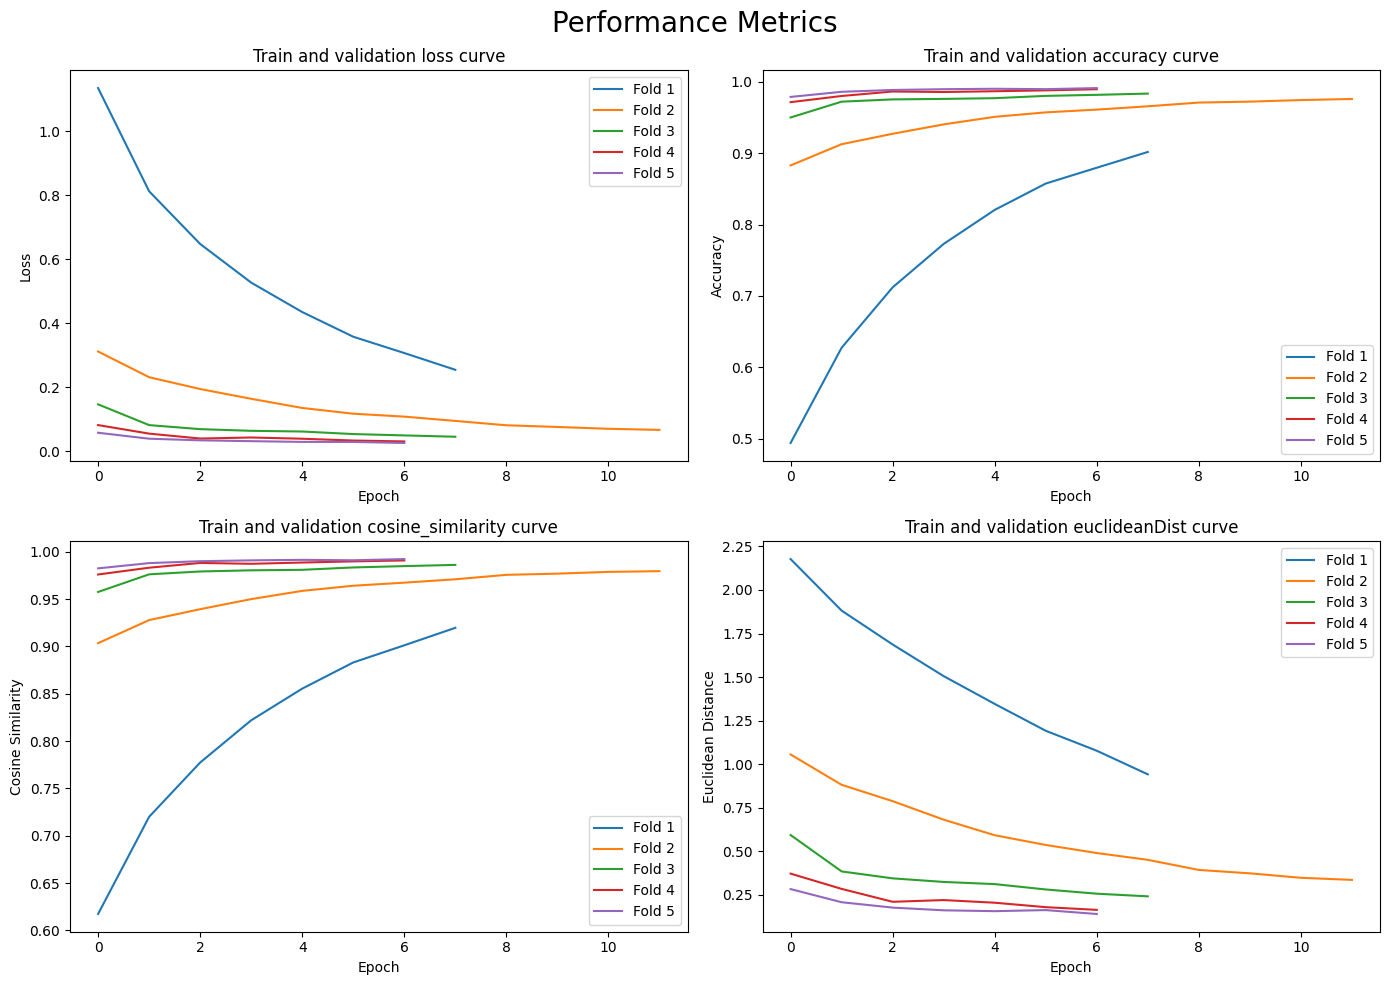

In [37]:

import matplotlib.pyplot as plt

def plot_result(histories):
    plt.figure(figsize=(14, 10))
    plt.suptitle("Performance Metrics", fontsize=20)
    
    metrics = ['loss', 'accuracy', 'cosine_similarity', 'euclideanDist']
    metric_titles = ['Loss', 'Accuracy', 'Cosine Similarity', 'Euclidean Distance']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        for j, hist in enumerate(histories):
            plt.plot(hist.history[metric], label=f'Fold {j+1}')
        plt.title(f'Train and validation {metric} curve')
        plt.xlabel('Epoch')
        plt.ylabel(metric_titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the performance metrics for each fold
plot_result(model_mobilenet_history)


In [20]:
def predict_retinopathy_level(image_array):
    # Load the trained machine learning model
    model = tf.keras.models.load_model(
        r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\model\model_mobilenet.keras", custom_objects={'euclideanDist': euclideanDist})

    # Make prediction using the loaded model
    prediction = model.predict(image_array)

    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]

    # Define default message
    message = ""

    # Define informative message based on predicted retinopathy level
    if predicted_class == 'No_DR':
        message = "😊 No Diabetic Retinopathy (NO DR): At this stage, there are typically no signs of retinal damage or abnormalities observed upon examination."
    elif predicted_class == 'Mild':
        message = "😐 Mild Nonproliferative DR: In this stage, small areas of balloon-like swelling in the tiny blood vessels of the retina (microaneurysms) may start to develop."
    elif predicted_class == 'Moderate':
        message = "😟 Moderate Nonproliferative DR: Microaneurysms are more numerous and may be slightly enlarged."
    elif predicted_class == 'Severe':
        message = "😧 Severe Nonproliferative DR: At this stage, there is a significant increase in the number and size of retinal hemorrhages."
    elif predicted_class == 'Proliferate_DR':
        message = "😨 Proliferative DR: This is the most advanced stage of diabetic retinopathy."

    return predicted_class, message

In [21]:
from tensorflow.keras.preprocessing import image
# Load and preprocess the image
img_path = r"C:\Users\FARHAN BASHIR\OneDrive\Desktop\Diabetic Retinopathy\archive\colored_images\Cleaned Images\Moderate\15_right.png"
img = image.load_img(img_path, target_size=IMG_SHAPE)  # Load the image
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image data

# Make prediction
predicted_class, message = predict_retinopathy_level(img_array)

print("Predicted class:", predicted_class)
print("Message:", message)

1/1 [==============================] - 5s 5s/step
Predicted class: Moderate
Message: 😟 Moderate Nonproliferative DR: Microaneurysms are more numerous and may be slightly enlarged.


In [7]:
import pickle
import numpy as np
import pandas as pd

def load_model_history(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def pred_vals(model_history):
    d = {}
    if model_history:
        # Initialize variables to track best test accuracy and corresponding metrics
        best_test_acc = 0
        best_euclidean_dist = 0
        best_cosine_similarity = 0
        best_metrics = {}

        # Iterate over each fold in the model history
        for fold_metrics in model_history:
            # Get test accuracy, euclidean distance, and cosine similarity for the current fold
            test_acc = fold_metrics.get('test_accuracy', 0)
            euclidean_dist = fold_metrics.get('test_euclidean_dist', 0)
            cosine_similarity = fold_metrics.get('test_cosine_similarity', 0)
            
            # Update best test accuracy and corresponding metrics if current test accuracy is higher
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_euclidean_dist = euclidean_dist
                best_cosine_similarity = cosine_similarity
                best_metrics = fold_metrics
      
        # Assign best metrics to the dictionary
        d['test_accuracy'] = best_test_acc
        d['test_euclidean_dist'] = best_euclidean_dist
        d['test_cosine_similarity'] = best_cosine_similarity
        d.update(best_metrics)  # Update other metrics from the fold with the best test accuracy
        
    return d




# Load model histories from .pk files
model_cnn_history =  [
    {'test_loss': 0.40326988697052, 'test_euclidean_dist': 0.8795999884605408,
     'test_accuracy': 0.896392822265625, 'test_cosine_similarity': 2.3357691764831543},
    {'test_loss': 0.3570708930492401, 'test_euclidean_dist': 0.9005333185195923,
     'test_accuracy': 0.914256751537323, 'test_cosine_similarity': 2.105482578277588},
    {'test_loss': 0.37650570273399353, 'test_euclidean_dist': 0.9062666893005371,
     'test_accuracy': 0.9180744886398315, 'test_cosine_similarity': 2.077004909515381},
    {'test_loss': 0.3701748847961426, 'test_euclidean_dist': 0.9036666750907898,
     'test_accuracy': 0.9180631637573242, 'test_cosine_similarity': 2.0622355937957764},
    {'test_loss': 0.44200924038887024, 'test_euclidean_dist': 0.9087333083152771,
     'test_accuracy': 0.9185922145843506, 'test_cosine_similarity': 2.074800491333008}
]
model_Xception_history = load_model_history(r"C:\Users\User\Desktop\models\model_Xception.pkl")
model_alexnet_history = load_model_history(r"C:\Users\User\Desktop\models\model_alexnet.pkl")
model_inception_history = load_model_history(r"C:\Users\User\Desktop\models\model_inception.pkl")
model_mobilenet_history = load_model_history(r"C:\Users\User\Desktop\models\model_mobilenet.pkl")
model_resnet_history = load_model_history(r"C:\Users\User\Desktop\models\model_resnett.pkl")

# Create dataframe
df_result = pd.DataFrame({
    'CNN': pred_vals(model_cnn_history),
    'Xception': pred_vals(model_Xception_history),
    'Alexnet': pred_vals(model_alexnet_history),
    'Inception V3': pred_vals(model_inception_history),
    'Mobilenet V3': pred_vals(model_mobilenet_history),
    'Resnet': pred_vals(model_resnet_history)
}).transpose().reset_index().rename(columns={'index': 'model'})
pd.set_option('display.width', 100)
# Display dataframe
print(df_result)


          model  test_accuracy  test_euclidean_dist  test_cosine_similarity  test_loss
0           CNN       0.918592             0.908733                2.074800   0.442009
1      Xception       0.818800             2.142435                0.830121   1.348378
2       Alexnet       0.781600             1.516006                0.815118   0.672225
3  Inception V3       0.819600             1.347334                0.853285   0.494287
4  Mobilenet V3       0.871133             1.094874                0.883927   0.612439
5        Resnet       0.876467             1.084664                0.886830   0.791695


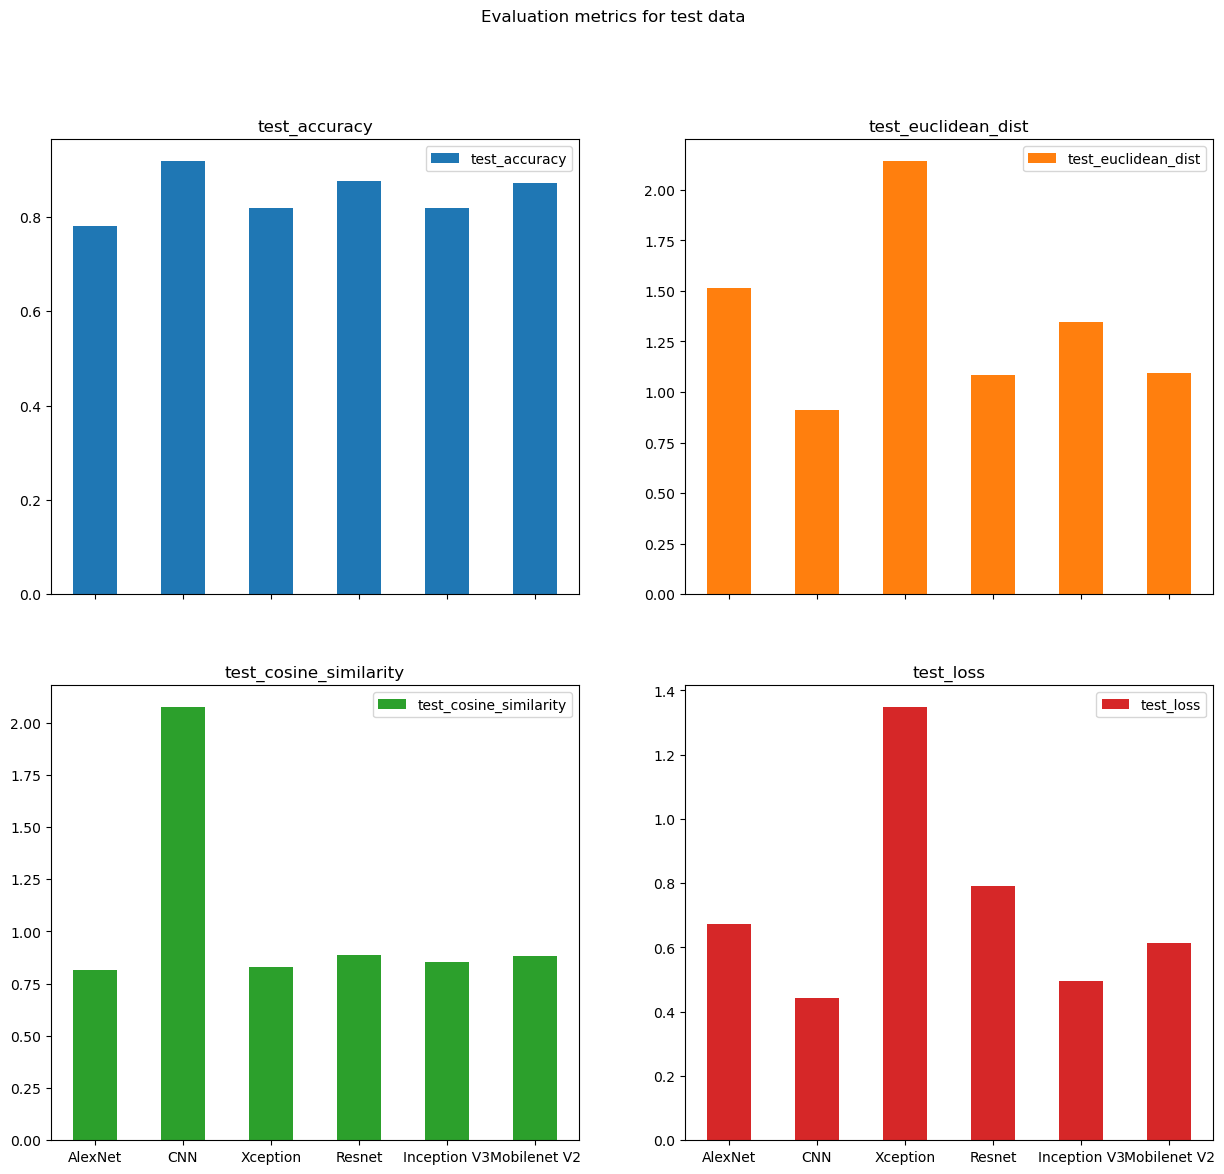

In [12]:
# Test results dataframe
test_results = pd.DataFrame([df_result.loc[2], df_result.loc[0], df_result.loc[1],df_result.loc[5], df_result.loc[3], df_result.loc[4]], index=["AlexNet", "CNN", "Xception","Resnet", "Inception V3", "Mobilenet V2"])

# Plotting
test_results.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 13), rot=0, title="Evaluation metrics for test data");
